In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements


Consider an optical system consisting of a source generating a Gaussian beam, a collecting lens, and a screen located in the rear focal plane of the lens. 

First, let us solve the forward problem and see what intensity distribution will be obtained if a beam passes through such a system. Then let us solve the inverse problem: knowing the intensity distribution on the screen after the passage of the optical system described above and the intensity distribution in the plane after the lens, let us try to find the transmission function of the lens.

Solve the direct propagation problem:

In [71]:
# optical setup size
lx = 10
ly = 10

# number of nodes
Nx = 1000
Ny = 1000
# wavelength
lam = 660 * 1e-6

# focal distance of the lens
focal = 100
# radius of the lens
r = 10
# distance between the screen od the lens
distance = focal

# waist radius of the gaussian beam
w0 = 0.5

x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)


dx = lx / Nx
dy = ly / Ny

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


Current set-up consisting of optical elements

In [72]:
field_before_lens1 = Wavefront.gaussian_beam(simulation_parameters=params, distance=5 * distance, waist_radius=w0)

intensity_source = field_before_lens1.intensity.detach().numpy()

lens1 = elements.ThinLens(simulation_parameters=params, focal_length=focal, radius=r)
# phase_func_lens = (torch.real(torch.log(lens1.get_transmission_function()) / 1j) + (2 * torch.pi)) % (2 * torch.pi)

field_after_lens1 = lens1.forward(input_field=field_before_lens1)

free_space1 = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='fresnel')
output_field = free_space1.forward(input_field=field_after_lens1)



phase_target = (torch.angle(output_field) + 2 * torch.pi * (torch.angle(output_field) < 0.).float()).detach().numpy()

intensity_target = torch.pow(torch.abs(output_field), 2).detach().numpy()



Now we are going to create low-api interface: if the user don't want to use our class LinearOpticalSetup and don't want to use our methods to solve the problem of direct wavefront propagation, it is possible to create the object SetupLike with with other methods of describing direct wavefront propagation through a given optical system. The class SetupLike is inherited from Protocol and must have two arbitrary methods: forward(for solving the problem of direct wavefront propagation through an optical system) and reverse(for solving the problem of reverse wavefront propagation through an optical system)

Example of use SetupLike is presented below.


In [73]:
class PersonalSetup:

    def __init__(
        self,
        element,
        simulation_parameters: SimulationParameters,
        distance: float
    ):

        self._elements = element
        self._distance = distance

        self.simulation_parameters = simulation_parameters

        self._x_size = self.simulation_parameters.x_size
        self._y_size = self.simulation_parameters.y_size
        self._x_nodes = self.simulation_parameters.x_nodes
        self._y_nodes = self.simulation_parameters.y_nodes
        self._wavelength = self.simulation_parameters.wavelength

        self._x_linspace = torch.linspace(
            -self._x_size/2, self._x_size/2, self._x_nodes
        )
        self._y_linspace = torch.linspace(
            -self._y_size/2, self._y_size/2, self._y_nodes
        )
        self._x_grid, self._y_grid = torch.meshgrid(
            self._x_linspace, self._y_linspace, indexing='xy'
        )

        self._kx_linear = torch.fft.fftfreq(self._x_nodes, torch.diff(
            self._x_linspace)[0]) * (2 * torch.pi)
        self._ky_linear = torch.fft.fftfreq(self._y_nodes, torch.diff(
            self._y_linspace)[0]) * (2 * torch.pi)
        self._kx_grid, self._ky_grid = torch.meshgrid(
            self._kx_linear, self._ky_linear, indexing='xy')

        self._wave_number = 2*torch.pi / self._wavelength

        # low-pass filter
        self.low_pass_filter = 1. * (torch.pow(self._kx_grid, 2) + torch.pow(
            self._ky_grid, 2) <= self._wave_number**2)


    def forward(self, incident_field: torch.Tensor) -> torch.Tensor:

        wave_number_z = torch.sqrt(
            self._wave_number**2 - torch.pow(self._kx_grid, 2) - torch.pow(self._ky_grid, 2)  # noqa: E501
        )


        incident_field_transmission = self._elements.forward(incident_field)

        impulse_response = self.low_pass_filter * torch.exp(
            1j * self._distance * wave_number_z / 100
        )

        transmission_field = impulse_response * incident_field_transmission

        return transmission_field

    def reverse(self, transmission_field: torch.Tensor) -> torch.Tensor:

        wave_number_z = torch.sqrt(
            self._wave_number**2 - torch.pow(self._kx_grid, 2) - torch.pow(self._ky_grid, 2)  # noqa: E501
        )

        impulse_response = self.low_pass_filter * torch.exp(
            -1j * self._distance * wave_number_z / 100
        )

        incident_field_transmission = transmission_field * impulse_response

        incident_field = self._elements.reverse(incident_field_transmission)

        return incident_field



In [74]:
optical_setup = PersonalSetup(free_space1, simulation_parameters=params, distance = 100.)

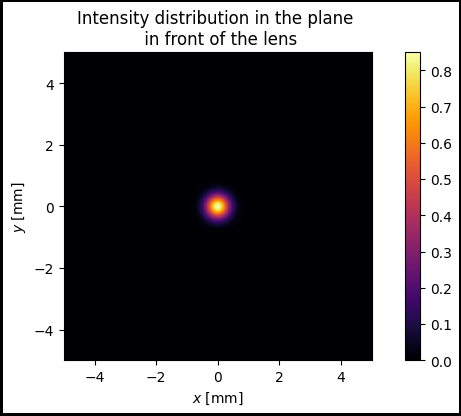

In [75]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_source, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity distribution in the plane \n in front of the lens')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

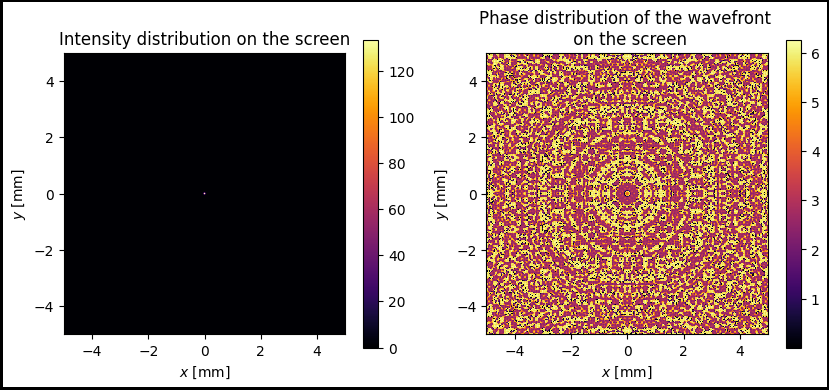

In [76]:
fig, ax = plt.subplots(
    1, 2, figsize=(10, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_target, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Intensity distribution on the screen')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, phase_target, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Phase distribution of the wavefront \n on the screen')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

Use module phase_retrieval.py for solving the phase reconstruction problem with Hybrid-Input-Output algorithm with using class SetupLike:

In [77]:
# goal region on the screen
goal = torch.tensor((xv**2 + yv **2 <=3.1).astype(float))


phase_distribution = phase_retrieval.retrieve_phase(
    source_intensity=torch.tensor(intensity_source),
    optical_setup=optical_setup,
    target_intensity=torch.tensor(intensity_target),
    target_phase=torch.tensor(phase_target),
    target_region=goal,
    initial_phase=None,
    method='HIO',
    maxiter=15,
    tol=1e-7
)

step = 2 * torch.pi / 256
mask = phase_distribution // step

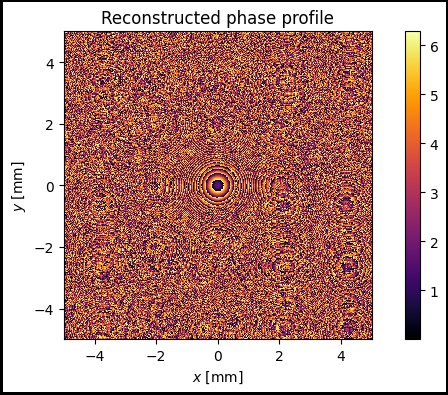

In [78]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, phase_distribution, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Reconstructed phase profile')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [79]:
field_after_slm = elements.SpatialLightModulator(simulation_parameters=params, mask=mask).forward(field_before_lens1)

output_field = optical_setup.forward(field_after_slm)
intensity_target_opt = torch.pow(torch.abs(output_field), 2).detach().numpy()

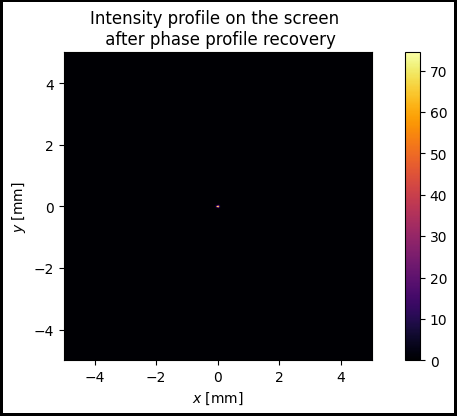

In [80]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity profile on the screen \n after phase profile recovery')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [81]:
E1 = np.sum(intensity_target_opt) * dx * dy
E2 = np.sum(intensity_target) * dx * dy


In [82]:
phase_opt = (torch.angle(output_field) + 2 * torch.pi * (torch.angle(output_field) < 0.).float()).detach().numpy()

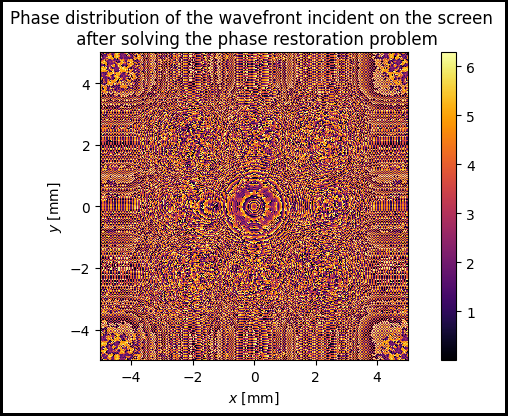

In [83]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, phase_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Phase distribution of the wavefront incident on the screen \n after solving the phase restoration problem')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)